# Natural Language Processing of NeIC Slack logs 

## First fetch the source

First clone with  
`git clone https://github.com/coderefinery/ahm18-nlp-slack.git`  
or  
`git clone git@github.com:coderefinery/ahm18-nlp-slack.git`  

and then  
```cd ahm18-nlp-slack
jupyter-notebook```

You will also need the Slack logs! These can be viewed at [https://wiki.neic.no/chat/](https://wiki.neic.no/chat/), but webscraping it is difficult.

Instead, go to this [Google Drive link](https://drive.google.com/open?id=1BVioZ9t15c1Ek7Xq067stN0ED28eXOsJ) and save the zipfile to the current directory (thanks to Joel)



## Some background on Jupyter Notebooks

### History of Jupyter
  - In 1991, Guido van Rossum publishes Python, which starts to gain in popularity
  - In 2001, Fernando Pérez started programming a fancier shell for Python called IPython
  - In 2014, Fernando Pérez announced a spin-off project from IPython called Project Jupyter. IPython will continue to exist as a Python shell and a kernel for Jupyter, while the notebook and other language-agnostic parts of IPython will move under the Jupyter name
 

### Why "Jupyter"?
 - Julia + Python + R	      
 - Jupyter is actually language agnostic and Jupyter kernels exist for dozens of programming languages
 - Galileo's publication in a pamphlet in 1610 in Sidereus Nuncius about observations of Jupiter's moons is formulated as a notebook, with illustrations, text, calculations, titles, datapoints, images, reasoning... One of the first notebooks!  
<img src="http://media.gettyimages.com/photos/pages-from-sidereus-nuncius-magna-by-galileo-galilei-a-book-of-and-picture-id90732970" width="500">

  

### Use cases
- Experimenting with new ideas, testing new libraries/databases 
- Interactive code and visualization development
- Sharing and explaining code to colleagues
- Learning from other notebooks
- Interactive data analysis
- Many cloud platforms offer access to Jupyter Notebooks 
- Keeping track of interactive sessions, like a digital lab notebook
- Supplementary information with published articles
- Teaching (programming, experimental/theoretical science)
- Presentations

### Cells

- **Code cells** contain code to be interpreted by the *kernel* (Python, R, Julia, Octave/Matlab...)
- **Markdown cells** contain formatted text written in Markdown 
![Components](img/notebook_components.png)

### Markdown cells

This cell contains simple [markdown](https://daringfireball.net/projects/markdown/syntax), a simple language for writing text that can be automatically converted to other formats, e.g. HTML, LaTeX or any of a number of others.

**Bold**, *italics*, **_combined_**, ~~strikethrough~~, `inline code`.

* bullet points

or

1. numbered
3. lists

**Equations:**   
inline $e^{i\pi} + 1 = 0$
or on new line  
$$e^{i\pi} + 1 = 0$$

Images ![CodeRefinery Logo](https://pbs.twimg.com/profile_images/875283559052980224/tQLhMsZC_400x400.jpg)

Links:  
[One of many markdown cheat-sheets](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#emphasis)


### Code cells

In [1]:
# a code cell can run statements of code.
# when you run this cell, the output is sent 
# from the web page to a back-end process, run 
# and the results are displayed to you
print("hello world")

hello world


The order of execution is important

In [2]:
x=1

In [3]:
x

1

In [4]:
x+=1

### Useful keyboard shortcuts 

Some shortcuts only work in Command or Edit mode.

* `Enter` key to enter Edit mode (`Escape` to enter Command mode)
* `Ctrl`-`Enter`: run the cell
* `Shift`-`Enter`: run the cell and select the cell below
* `Alt`-`Enter`: run the cell and insert a new cell below
* `Ctrl`-`s`: save the notebook 
* `Tab` key for code completion or indentation (Edit mode)
* `m` and `y` to toggle between Markdown and Code cells (Command mode)
* `d-d` to delete a cell (Command mode)
* `z` to undo deleting (Command mode)
* `a/b` to insert cells above/below current cell (Command mode)
* `x/c/v` to cut/copy/paste cells (Command mode)
* `Up/Down` or `k/j` to select previous/next cells (Command mode)
* `h` for help menu for keyboard shortcuts (Command mode)
* Append `?` for help on commands/methods, `??` to show source (Edit mode) 

> **Exercise**: Spend a few minutes playing around in the notebook. Add cells, toggle between Markdown and Code, execute some code, write some markdown. Try the keyboard shortcuts

### Links and further reading
 - http://nbviewer.jupyter.org/
 - https://github.com/jupyter/jupyter/wiki/A-gallery-of-interesting-Jupyter-Notebooks
 - http://mybinder.org/
 - https://jupyterhub.readthedocs.io/en/latest/
 - http://ipython-books.github.io/minibook/
 - http://ipython-books.github.io/cookbook/
 - https://www.oreilly.com/ideas/the-state-of-jupyter

## Analyzing Slack logs

Let's get down to business.  
Hopefully everyone has the following packages installed:
- `numpy`, `pandas`, `matplotlib`, `jupyter`, `nltk`, `textmining`, `lda`, `emoji`, `json`, `re`, `datetime`

### Import packages

In [5]:
import os
import sys
print(sys.version)
#sys.setdefaultencoding('utf8')
from __future__ import division

2.7.14 | packaged by conda-forge | (default, Nov  4 2017, 10:22:41) 
[GCC 4.2.1 Compatible Apple LLVM 6.1.0 (clang-602.0.53)]


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [7]:
import re
import json
import emoji
import lda
import textmining
import datetime
import nltk 

### Extracting the logs

Below we have a code cell, but it's not Python! Have a look at the first line. `%%bash` is a *cell magic* which tells Jupyter to interpret the contents of the cell as bash commands

In [8]:
%%bash
mkdir slack_logs
cd slack_logs
mv ../NeIC_Slack_export_Dec10_2017.zip .
unzip NeIC_Slack_export_Dec10_2017.zip
cd ..

Archive:  NeIC_Slack_export_Dec10_2017.zip


mkdir: slack_logs: File exists
mv: ../NeIC_Slack_export_Dec10_2017.zip: No such file or directory
replace random/2017-09-22.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [c]
replace random/2017-09-22.json? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(assuming [N]one)


### Inspect directory structure and file format

In the code cell below we have a *line magic* `%sx` (with one `%` sign) which runs a shell command (using `commands.getoutput()`) and captures the output.  

If you want to see what magic commands are available, type `%lsmagic` in a code cell. Magics depend on what kernel is used, and new magics can also be installed (and created!).

In [9]:
dirs = %sx ls -d slack_logs/*/
for n,i in enumerate(dirs):
    print(n,i)

(0, 'slack_logs/2nd-ndsw/')
(1, 'slack_logs/_aa/')
(2, 'slack_logs/aai/')
(3, 'slack_logs/ahm-planning/')
(4, 'slack_logs/ahm-social/')
(5, 'slack_logs/ahm/')
(6, 'slack_logs/ahm16/')
(7, 'slack_logs/ahm17/')
(8, 'slack_logs/arc-debugging/')
(9, 'slack_logs/arc-operations/')
(10, 'slack_logs/bdi/')
(11, 'slack_logs/ce-debugging/')
(12, 'slack_logs/coc/')
(13, 'slack_logs/coderefinery/')
(14, 'slack_logs/data/')
(15, 'slack_logs/dcache/')
(16, 'slack_logs/dellingr/')
(17, 'slack_logs/docker/')
(18, 'slack_logs/esm/')
(19, 'slack_logs/fgi/')
(20, 'slack_logs/fla/')
(21, 'slack_logs/general/')
(22, 'slack_logs/glenna/')
(23, 'slack_logs/hpc-core_conference_c/')
(24, 'slack_logs/kudohugbox/')
(25, 'slack_logs/loke/')
(26, 'slack_logs/metacenter/')
(27, 'slack_logs/music/')
(28, 'slack_logs/ndgf-247/')
(29, 'slack_logs/ndgf/')
(30, 'slack_logs/ndgf_groupchat_nordu_/')
(31, 'slack_logs/neic2017/')
(32, 'slack_logs/nimbus/')
(33, 'slack_logs/nlpl/')
(34, 'slack_logs/perfsonardeploy/')
(35, 's

> **Exercise:** Add a code cell below. Use either a bash cell magic or a sx line magic to remove the `_aa` directory under `slack_logs` (this channel is empty)

#### Let's first explore one channel

In [10]:
dir = dirs[13] #coderefinery
os.listdir(dir)

['2016-02-22.json',
 '2016-03-08.json',
 '2016-03-09.json',
 '2016-03-10.json',
 '2016-03-11.json',
 '2016-03-18.json',
 '2016-03-31.json',
 '2016-04-03.json',
 '2016-04-04.json',
 '2016-04-12.json',
 '2016-04-14.json',
 '2016-05-01.json',
 '2016-05-02.json',
 '2016-05-11.json',
 '2016-05-17.json',
 '2016-05-20.json',
 '2016-05-22.json',
 '2016-05-23.json',
 '2016-06-13.json',
 '2016-06-14.json',
 '2016-06-20.json',
 '2016-07-07.json',
 '2016-07-08.json',
 '2016-07-29.json',
 '2016-08-16.json',
 '2016-08-17.json',
 '2016-08-22.json',
 '2016-08-29.json',
 '2016-08-30.json',
 '2016-09-02.json',
 '2016-09-06.json',
 '2016-09-07.json',
 '2016-09-12.json',
 '2016-09-13.json',
 '2016-09-14.json',
 '2016-09-22.json',
 '2016-09-27.json',
 '2016-09-28.json',
 '2016-09-29.json',
 '2016-09-30.json',
 '2016-10-03.json',
 '2016-10-04.json',
 '2016-10-05.json',
 '2016-10-06.json',
 '2016-10-07.json',
 '2016-10-08.json',
 '2016-10-09.json',
 '2016-10-10.json',
 '2016-10-11.json',
 '2016-10-12.json',


Look at the structure of the json files

In [11]:
dates = os.listdir(dir)
d = dates[0] # pick the first date

# read in contents of json file
with open(dir+d,"r") as f:
    raw_json = json.loads(f.read())

# dump json
dump = json.dumps(raw_json,indent=4)
print(dump)

[
    {
        "subtype": "channel_join", 
        "type": "message", 
        "user": "U0A9NV7PX", 
        "ts": "1456141994.000002", 
        "text": "<@U0A9NV7PX> has joined the channel"
    }, 
    {
        "text": "<@U0KV7FVNV> has joined the channel", 
        "ts": "1456141994.000003", 
        "subtype": "channel_join", 
        "inviter": "U0A9NV7PX", 
        "type": "message", 
        "user": "U0KV7FVNV"
    }, 
    {
        "text": "Is the name now official? If yes, then I will set up a rudimentary website. This would help me to contact people, then I have a link to refer them to.", 
        "type": "message", 
        "user": "U0KV7FVNV", 
        "ts": "1456142521.000004"
    }
]


Aha, `subtype` only present if it's not a regular message. We also see that each message has a unix epoch timestamp.

### Extracting messages

We now extract all regular messages in one channel

In [12]:
dates = os.listdir(dir) # this is still the coderefinery channel
messages = []

for d in dates: 
    with open(dir+d,"r") as f:
        raw_json = json.loads(f.read())

    for j in raw_json:
        if not "subtype" in j.keys(): # exclude non-message messages
            messages.append(j["text"])


Add all words in all messages to one list

In [13]:
words = []
for m in messages:
    [words.append(w.lower()) for w in m.split()]
    
words[-20:]

[u'sabry,',
 u'best',
 u'wishes',
 u'for',
 u'your',
 u'family!',
 u'thank',
 u'you',
 u'wonderful',
 u'news!',
 u'congratulations!',
 u"don't",
 u'worry',
 u'about',
 u'the',
 u'ticket.',
 u'wonderful',
 u'news,',
 u'congratulations',
 u'sabry!!']

#### Let's do this for all the Slack channels

In [14]:
# list with all channel names
all_channels = [d.replace("slack_logs/","").replace("/","") for d in dirs]

# dictionary with channel names as keys
words_in_channels = dict.fromkeys(all_channels)

In [15]:
# function to join messages into one long array
def join_messages(messages):
    words = []
    for m in messages:
        [words.append(w.lower()) for w in m.split()]
    return words


We now join all words in all channels. Is this time-consuming? Let's time it with the `%%timeit` cell magic!

In [16]:
%%timeit -n 1 -r 1
# join messages in all channels into elements of words_in_channels dict
for channel in all_channels:
    dates = os.listdir("slack_logs/"+channel)
    messages = []
    for d in dates: 
        with open("slack_logs/"+channel+"/"+d,"r") as f:
            raw_json = json.loads(f.read())

        for j in raw_json:
            if not "subtype" in j.keys(): # exclude non-message messages
                messages.append(j["text"])
    words_in_channels[channel] = join_messages(messages)
    print("channel {} has {} words".format(channel,len(words_in_channels[channel])))

channel 2nd-ndsw has 1644 words
channel _aa has 0 words
channel aai has 1 words
channel ahm-planning has 11713 words
channel ahm-social has 0 words
channel ahm has 5777 words
channel ahm16 has 4555 words
channel ahm17 has 38 words
channel arc-debugging has 63748 words
channel arc-operations has 1140 words
channel bdi has 867 words
channel ce-debugging has 0 words
channel coc has 257 words
channel coderefinery has 88519 words
channel data has 244 words
channel dcache has 0 words
channel dellingr has 211 words
channel docker has 15 words
channel esm has 668 words
channel fgi has 0 words
channel fla has 0 words
channel general has 54968 words
channel glenna has 3990 words
channel hpc-core_conference_c has 0 words
channel kudohugbox has 636 words
channel loke has 18 words
channel metacenter has 0 words
channel music has 2014 words
channel ndgf-247 has 2393 words
channel ndgf has 1052791 words
channel ndgf_groupchat_nordu_ has 0 words
channel neic2017 has 27186 words
channel nimbus has 0 wo

Remove empty channels

In [17]:
words_in_channels = { k:v for k,v in words_in_channels.items() if len(v)!=0 }

Plot number of words in channels using Seaborn barplot

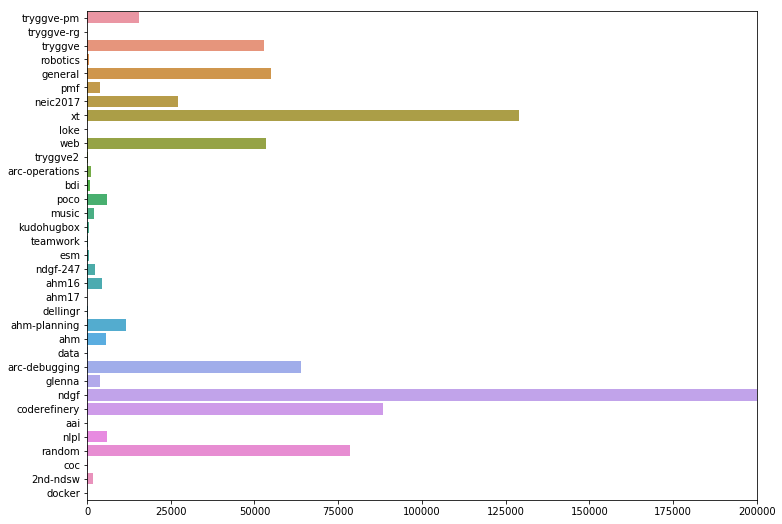

In [18]:
plt.rcParams["figure.figsize"] = [12,9]
x = words_in_channels.keys()
y = [len(words_in_channels[i]) for i in words_in_channels.keys()]
ax = sns.barplot(x=y, y=x);

ax.set_xlim([0,200000]);

From now on, let's focus on the largest channels (and include `ahm-planning` for good measure)

In [19]:
channels = ["tryggve","general","xt","web","random","arc-debugging","ndgf","coderefinery", "ahm-planning"]

### Simple natural language processing

Natural language toolkit tests

In [20]:
# tab completion can be used to see available methods of a module
#nltk.

#### Frequency distribution of words

In [21]:
# we can view docstrings for functions in python modules: 
nltk.FreqDist?

In [22]:
# and the source code itself can be viewed by using two question marks!
nltk.FreqDist??

Find frequency distribution of words, but excluding stopwords!

In [23]:
from nltk.corpus import stopwords

most_common_words = dict.fromkeys(channels,0)
dists = dict.fromkeys(channels,0)
stop = stopwords.words('english')
for channel in channels:
   words = words_in_channels[channel]
   words = [token for token in words if token not in stop]
   dist = nltk.FreqDist(words)
   dists[channel] = dist
   most_common_words[channel] = dist.most_common(20)

#### Pandas dataframes

We create a dataframe to work with:

In [24]:
# we can feed a dictionary to the `DataFrame` method
df_words = pd.DataFrame(data=most_common_words)
df_words.head(30)

,ahm-planning,arc-debugging,coderefinery,general,ndgf,random,tryggve,web,xt
0,"(could, 60)","(jobs, 331)","(-, 838)","(-, 198)","(one, 2885)","(one, 293)","(tryggve, 333)","(would, 213)","(meeting, 506)"
1,"(would, 55)","(file, 262)","(good, 438)","(like, 189)","(get, 2666)","(get, 258)","(meeting, 277)","(need, 184)","(good, 458)"
2,"(people, 53)","(files, 245)","(would, 396)","(neic, 180)","(-, 2647)","(like, 245)","(could, 160)","(could, 168)","(xt, 436)"
3,"(good, 48)","(one, 213)","(also, 363)","(would, 175)","(think, 2443)","(time, 192)","(use, 149)","(like, 160)","(i'm, 405)"
4,"(meeting, 46)","(arc, 209)","(think, 304)","(good, 150)","(i'm, 2422)","(i'm, 170)","(good, 140)","(one, 153)","(could, 362)"
5,"(think, 43)","(see, 207)","(people, 291)","(one, 139)","(i'll, 2368)","(got, 168)","(would, 139)","(people, 152)","(would, 347)"
6,"(:slightly_smiling_face:, 41)","(like, 169)","(one, 284)","(use, 136)","(dcache, 2351)","(would, 158)","(need, 130)","(-, 148)","(one, 336)"
7,"(yes,, 40)","(think, 162)","(like, 281)","(people, 134)","(see, 2272)","(good, 150)","(think, 130)","(think, 146)","(like, 329)"
8,"(one, 38)","(yes,, 157)","(need, 281)","(also, 133)","(need, 2261)","(:slightly_smiling_face:, 144)","(one, 128)","(also, 140)","(get, 299)"
9,"(hands-on, 35)","(time, 154)","(get, 211)","(get, 133)","(new, 2221)","(think, 138)","(see, 124)","(get, 131)","(think, 291)"


In [25]:
# we can get a list of unique common words with a set()
common_words = set()
for index, row in df_words.iterrows():
    for r in row:
        common_words.add(r[0])
for i in common_words:
    print(i)

i'll
tryggve
want
people
please
neic
one
see
arc
dcache
thanks
file
registration
need
tiggi:
still
dmytrok:
xt
really
web
use
yes,
would
<@u054a37e2>
make
cache
-
send
also
workshop
got
a-rex
meeting
files
[info]
good
jobs
get
job
know
new
hands-on
problem
<@u069f8tst>
:slightly_smiling_face:
ok
like
maybe
could
work
<@u050w0wap>
project
session
time
pools
dtr
i'm
hangout
think
that's


### Lexical diversity (type-token ratio)

Let's look at lexical diversity, i.e. the ratio of number of distinct words and total number of words

In [26]:
def lexical_diversity(text):
    return len(set(text)) / len(text)

In [27]:
for channel in channels: # loop over the largest channels
    words = words_in_channels[channel]
    lex_div = lexical_diversity(words)
    print("Lexical diversity in %s is %f"%(channel,lex_div))

Lexical diversity in tryggve is 0.169294
Lexical diversity in general is 0.191821
Lexical diversity in xt is 0.138659
Lexical diversity in web is 0.169905
Lexical diversity in random is 0.204878
Lexical diversity in arc-debugging is 0.150530
Lexical diversity in ndgf is 0.066855
Lexical diversity in coderefinery is 0.127306
Lexical diversity in ahm-planning is 0.224878


Linguistic richness is clearly greatest in `ahm-planning`, closely followed by `random` and `general`!

### Collocations, contexts and similar words

In [28]:
nltk.Text.collocations?

**Collocations (sequences of words that co-occur more often than expected by chance)**

In [29]:
for channel in channels:
    words = words_in_channels[channel]
    all_words = " ".join(words)
    tokens = nltk.word_tokenize(all_words)
    text = nltk.Text(tokens)
    print(channel)
    print("------------")
    text.collocations()
    print("------------------------------------------------")
    print("")

tryggve
------------
tryggve hangout; live minutes; weekly meeting; use case; local ega;
meeting today; 13:00 cet; next week; tryggve weekly; feel free;
popular kudos; kudos received; sftp beamer; normal time; sensitive
data; last week; tyttebär hangout; looks like; trello cards; joakim
dillner
------------------------------------------------

general
------------
would like; good luck; n't know; internal wiki; google docs; neic
board; looks like; open source; live minutes; next week; looking
forward; 3.0 workout; pull requests; board meeting; `0` reactions;
feel free; hands meeting; take care; sensitive data; nordic software
------------------------------------------------

xt
------------
good morning; next week; stakeholder engagement; resource sharing;
missing abstract; sensitive data; feel free; looks like; google drive;
poco planning; steering group; board meeting; use cases; internal
wiki; session day; would like; sounds like; live minutes; neic 2017;
project directive
---------

tyttebär hangout??

**Similar contexts**

In [30]:
nltk.Text.similar?

In [31]:
for channel in channels:
    words = words_in_channels[channel]
    all_words = " ".join(words)
    tokens = nltk.word_tokenize(all_words)
    text = nltk.Text(tokens)
    print(channel)
    print("------------")
    text.similar("good")
    print("------------------------------------------------")
    print("")


tryggve
------------
nice up better possible hard thanks easier available ok useful able
soon yes fine interesting seems waiting easy then now
------------------------------------------------

general
------------
nice the possible long hard easy short used real bit cool great decent
cf happy similar is same new serious
------------------------------------------------

xt
------------
interesting useful great this not relevant ok that possible but okay
it ready well there to fine new better now
------------------------------------------------

web
------------
fine better ok nice okay possible that easy safe bad used over thanks
yes trying pointing trivial simple easier meant
------------------------------------------------

random
------------
bad supposed not difficult hard free it nice used possible just
planning going easy reasonable small mandatory new willing great
------------------------------------------------

arc-debugging
------------
nice updated bad have found hard used l

**Searching for words**

> **Exercise:** Another method of `nltk.Text` is `concordance`, which finds all matches in a body of text for a given word or phrase.  
1. Have a look at the docstring for `nltk.Text.concordance` to see how it's used.
2. Copy-paste either the `collocation` or `similar` cell from above using keyboard shortcuts `C` and `V`.
3. Edit the cell to use the `concordance` method, with a word or phrase of your choice 
4. Share if you find something interesting!

## "Sentiment analysis": emojis!

Emojis in the Slack logs are expressed like `:slightly_smiling_face:` 

Let's find all the emojis first by joining all words from all channels and regex-ing it, and then find the most frequent ones

In [32]:
# join words from all channels into one list, and then join into one long "sentence"
words = [j for i in words_in_channels.values() for j in i] 
all_words = " ".join(words)

emojis = re.findall(r":[a-zA-Z_]+:",all_words) # this filters out strings like :43:

dist = nltk.FreqDist(emojis)
dist.most_common(30)


[(u':slightly_smiling_face:', 1666),
 (u':simple_smile:', 582),
 (u':wink:', 321),
 (u':smile:', 244),
 (u':disappointed:', 212),
 (u':clap:', 71),
 (u':thumbsup:', 66),
 (u':stuck_out_tongue:', 56),
 (u':grinning:', 43),
 (u':star:', 34),
 (u':champagne:', 33),
 (u':tada:', 32),
 (u':e:', 30),
 (u':blush:', 26),
 (u':confused:', 23),
 (u':mm:', 22),
 (u':beef:', 20),
 (u':beers:', 20),
 (u':fire:', 19),
 (u':sunglasses:', 19),
 (u':tyttebar:', 18),
 (u':coffee:', 17),
 (u':cc:', 17),
 (u':relieved:', 17),
 (u':newspaper:', 16),
 (u':sweat_smile:', 15),
 (u':cake:', 14),
 (u':cafe:', 14),
 (u':joy:', 13),
 (u':dc:', 12)]

Let's investigate a few key emojis

In [33]:
common_emojis = [u":disappointed:",u":wink:",u":slightly_smiling_face:",u":simple_smile:",
              u":thumbsup:",u":clap:",u":stuck_out_tongue:",u":smile:",u":grinning:"]

for i in common_emojis:
    print(emoji.emojize('NeIC is %s'%i, use_aliases=True)) 
    print(i)
    print("------------------")

NeIC is 😞
:disappointed:
------------------
NeIC is 😉
:wink:
------------------
NeIC is 🙂
:slightly_smiling_face:
------------------
NeIC is :simple_smile:
:simple_smile:
------------------
NeIC is 👍
:thumbsup:
------------------
NeIC is 👏
:clap:
------------------
NeIC is 😛
:stuck_out_tongue:
------------------
NeIC is 😄
:smile:
------------------
NeIC is 😀
:grinning:
------------------


hmm, `emoji` package doesn't understand `:simple_smile:`

Let's count how often emojis are used in the different channels

In [34]:
channel_emojis = dict.fromkeys(channels,0)
 
for channel in channels:
    words = words_in_channels[channel]
    count = [words.count(i) for i in common_emojis]
    channel_emojis[channel] = count

channel_emojis

{'ahm-planning': [2, 0, 41, 0, 0, 0, 0, 2, 0],
 'arc-debugging': [11, 11, 111, 24, 0, 0, 0, 0, 0],
 'coderefinery': [4, 14, 189, 2, 1, 0, 6, 6, 1],
 'general': [4, 39, 120, 47, 2, 3, 2, 17, 4],
 'ndgf': [121, 60, 527, 321, 1, 0, 10, 38, 1],
 'random': [18, 45, 144, 36, 6, 6, 10, 37, 1],
 'tryggve': [17, 30, 118, 34, 2, 21, 6, 33, 10],
 'web': [4, 7, 98, 9, 0, 2, 6, 21, 0],
 'xt': [18, 61, 103, 66, 29, 20, 9, 44, 5]}

Put the dict into a DataFrame for easy manipulation

In [35]:
df_emojis = pd.DataFrame(data=channel_emojis)
df_emojis.head(10)

,ahm-planning,arc-debugging,coderefinery,general,ndgf,random,tryggve,web,xt
0,2,11,4,4,121,18,17,4,18
1,0,11,14,39,60,45,30,7,61
2,41,111,189,120,527,144,118,98,103
3,0,24,2,47,321,36,34,9,66
4,0,0,1,2,1,6,2,0,29
5,0,0,0,3,0,6,21,2,20
6,0,0,6,2,10,10,6,6,9
7,2,0,6,17,38,37,33,21,44
8,0,0,1,4,1,1,10,0,5


Let's use real emojis as indices in the dataframe

In [36]:
emojis=[]
for i in common_emojis:
    x = emoji.emojize(i, use_aliases=True) 
    emojis.append(x)
df_emojis["emojis"] = emojis
df_emojis.set_index('emojis',inplace=True, drop=True)
df_emojis.head(10)

,ahm-planning,arc-debugging,coderefinery,general,ndgf,random,tryggve,web,xt
emojis,,,,,,,,,
😞,2,11,4,4,121,18,17,4,18
😉,0,11,14,39,60,45,30,7,61
🙂,41,111,189,120,527,144,118,98,103
:simple_smile:,0,24,2,47,321,36,34,9,66
👍,0,0,1,2,1,6,2,0,29
👏,0,0,0,3,0,6,21,2,20
😛,0,0,6,2,10,10,6,6,9
😄,2,0,6,17,38,37,33,21,44
😀,0,0,1,4,1,1,10,0,5


Doesn't look good with the unsupported emoji. Let's sum simple_smile into slightly_smiling_face (we in the Nordics don't have such fine-grained positive emotions)

In [37]:
row_keep = df_emojis.index[2]
row_delete = df_emojis.index[3]

In [38]:
# add row_delete to row_keep, and delete row_delete
df_emojis.loc[row_keep] += df_emojis.loc[row_delete]
df_emojis.drop([row_delete], inplace=True)

df_emojis


,ahm-planning,arc-debugging,coderefinery,general,ndgf,random,tryggve,web,xt
emojis,,,,,,,,,
😞,2,11,4,4,121,18,17,4,18
😉,0,11,14,39,60,45,30,7,61
🙂,41,135,191,167,848,180,152,107,169
👍,0,0,1,2,1,6,2,0,29
👏,0,0,0,3,0,6,21,2,20
😛,0,0,6,2,10,10,6,6,9
😄,2,0,6,17,38,37,33,21,44
😀,0,0,1,4,1,1,10,0,5


Normalize to total number of selected emojis in each channel to get final result

In [39]:
df_tmp = 100*df_emojis/df_emojis.sum()
df_tmp.round(1)

,ahm-planning,arc-debugging,coderefinery,general,ndgf,random,tryggve,web,xt
emojis,,,,,,,,,
😞,4.4,7.0,1.8,1.7,11.2,5.9,6.3,2.7,5.1
😉,0.0,7.0,6.3,16.4,5.6,14.9,11.1,4.8,17.2
🙂,91.1,86.0,85.7,70.2,78.6,59.4,56.1,72.8,47.6
👍,0.0,0.0,0.4,0.8,0.1,2.0,0.7,0.0,8.2
👏,0.0,0.0,0.0,1.3,0.0,2.0,7.7,1.4,5.6
😛,0.0,0.0,2.7,0.8,0.9,3.3,2.2,4.1,2.5
😄,4.4,0.0,2.7,7.1,3.5,12.2,12.2,14.3,12.4
😀,0.0,0.0,0.4,1.7,0.1,0.3,3.7,0.0,1.4


### Conclusions

- NeIC people express quite positive emotions overall 
- There's not a lot of clapping and thumbs-up-giving, except for `XT` people who do both, and `Tryggve` people enjoy clapping 
- On the other hand, `XT`-ers don't smile as much as other channels, but they do laugh a bit
- People in `web` stick out their tongue more than average
- `arc-debugging` and `ahm-planning` folks are rather limited in their emotional repertoire  
- The most ambiguous communication takes place on `random` and `general`, as evidenced by the high proportion of winking
- `NDGF`-ers are the most disappointed channel. Anything we can do to help guys? 😉 

### Topic modeling with latent Dirichlet allocation (LDA) 

Topic models are statistical models for discovering topics that occur in a set of documents. For a visual representation of what goes on in topic modelling, [see this animation](https://upload.wikimedia.org/wikipedia/commons/7/70/Topic_model_scheme.webm).  

[LDA](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation#cite_note-blei2003-1) is probably the most commonly used topic model today and was introduced by [David Blei, Andrew Ng and Michael I. Jordan](http://www.jmlr.org/papers/v3/blei03a.html).

We need to do some preprocessing. First join all words for each channel

In [40]:
joined_words_in_channels = dict.fromkeys(channels)
for i in channels:
    words = words_in_channels[i]
    joined_words_in_channels[i] = " ".join(words)


`textmining` is a useful package to create the [term-document matrix](https://en.wikipedia.org/wiki/Document-term_matrix)

In [41]:
tdm = textmining.TermDocumentMatrix()
# add documents to the term-document matrix (each channel is a document)
for channel in channels:
    tdm.add_doc(joined_words_in_channels[channel])

# write term document matrix to csv file
tdm.write_csv('matrix.csv', cutoff=1)


In [42]:
vocab = list(tdm.rows(cutoff=1))[0]
titles = channels
X = np.array(list(tdm.rows(cutoff=1))[1:])

X.shape

(9, 34357)

In [43]:
n_topics = 20
model = lda.LDA(n_topics=n_topics, n_iter=1500, random_state=1)
model.fit(X)  # model.fit_transform(X) is also available


INFO:lda:n_documents: 9
INFO:lda:vocab_size: 34357
INFO:lda:n_words: 1732501
INFO:lda:n_topics: 20
INFO:lda:n_iter: 1500
INFO:lda:<0> log likelihood: -17807564
INFO:lda:<10> log likelihood: -16074106
INFO:lda:<20> log likelihood: -15338162
INFO:lda:<30> log likelihood: -15009240
INFO:lda:<40> log likelihood: -14804158
INFO:lda:<50> log likelihood: -14641878
INFO:lda:<60> log likelihood: -14518133
INFO:lda:<70> log likelihood: -14410646
INFO:lda:<80> log likelihood: -14303685
INFO:lda:<90> log likelihood: -14202283
INFO:lda:<100> log likelihood: -14115673
INFO:lda:<110> log likelihood: -14046338
INFO:lda:<120> log likelihood: -13956617
INFO:lda:<130> log likelihood: -13881262
INFO:lda:<140> log likelihood: -13814060
INFO:lda:<150> log likelihood: -13740841
INFO:lda:<160> log likelihood: -13679280
INFO:lda:<170> log likelihood: -13623929
INFO:lda:<180> log likelihood: -13568975
INFO:lda:<190> log likelihood: -13511990
INFO:lda:<200> log likelihood: -13467850
INFO:lda:<210> log likelihood

<lda.lda.LDA instance at 0x124e13200>

From the fit model we can look at the topic-words. Let's look at the top 15 words for each topic by probability

In [44]:
topic_word = model.topic_word_  # model.components_ also works
n_top_words = 20
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('*Topic {}\n- {}'.format(i, ' '.join(topic_words)))

*Topic 0
- the it i to is a and that s but t of in for at on not you can we
*Topic 1
- the a i and of in to you s that they is was it for my have with but time
*Topic 2
- pool ll dcache we update nagios chrulle yeah pools maswan t alice behrmann reboot m host test dk tiggi after
*Topic 3
- u tryggve you meeting q s i https a e my hangout com we at google today w wap kudos
*Topic 4
- didn your things home oslo real made pretty fi better long only start night high today hour three o last
*Topic 5
- problem what put same make done want service sure issue info move run file things stuff page source email slightly
*Topic 6
- java ms ood week sec face net domain done site kildetoft needed johan saerda gw graphs mbytes page tsm add
*Topic 7
- in and google neic for the will to you project meeting good all what have see channel thanks tomorrow ahm
*Topic 8
- we i and u will coderefinery workshop to my good but git it fvnv kv ok github people can also
*Topic 9
- ok alice ku pools srm petter no 

The other information we get from the model is document-topic probabilities

In [45]:
doc_topic = model.doc_topic_
for n in range(len(channels)):
    topic_most_pr = doc_topic[n].argmax()
    print("doc: {} topic: {}\n{}...".format(n,topic_most_pr,titles[n][:50]))

doc: 0 topic: 19
tryggve...
doc: 1 topic: 19
general...
doc: 2 topic: 19
xt...
doc: 3 topic: 19
web...
doc: 4 topic: 19
random...
doc: 5 topic: 0
arc-debugging...
doc: 6 topic: 0
ndgf...
doc: 7 topic: 19
coderefinery...
doc: 8 topic: 19
ahm-planning...


Ok, that wasn't interesting. The top topics are just help words

Let's plot the topics instead, and exclude topics 0 and 19

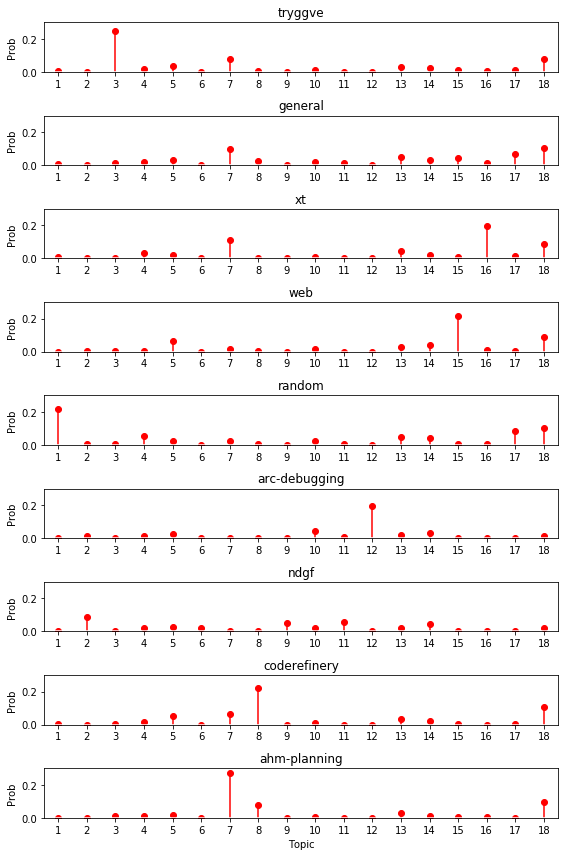

In [46]:
f, ax= plt.subplots(len(channels), 1, figsize=(8, 12))
for k in range(len(channels)):
    ax[k].stem(doc_topic[k,:], linefmt='r-',
               markerfmt='ro', basefmt='w-')
    ax[k].set_xlim(0.5, 18.5)
    ax[k].set_xticks(range(1,19))
    ax[k].set_ylim(0, .3)
    ax[k].set_ylabel("Prob")
    ax[k].set_title("{}".format(channels[k]))

ax[-1].set_xlabel("Topic")

plt.tight_layout()
plt.show()

For reference, let's also make a HTML table

In [47]:
table=[[] for i in range(len(topic_word))]
for i, topic_dist in enumerate(topic_word):
    table[i].append(str(i))
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    table[i].append(' '.join(topic_words))


from IPython.display import HTML, display
display(HTML('<table><tr>{}</tr></table>'.format('</tr><tr>'.join(
            '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in table))))

0,the it i to is a and that s but t of in for at on not you can we
1,the a i and of in to you s that they is was it for my have with but time
2,pool ll dcache we update nagios chrulle yeah pools maswan t alice behrmann reboot m host test dk tiggi after
3,u tryggve you meeting q s i https a e my hangout com we at google today w wap kudos
4,didn your things home oslo real made pretty fi better long only start night high today hour three o last
5,problem what put same make done want service sure issue info move run file things stuff page source email slightly
6,java ms ood week sec face net domain done site kildetoft needed johan saerda gw graphs mbytes page tsm add
7,in and google neic for the will to you project meeting good all what have see channel thanks tomorrow ahm
8,we i and u will coderefinery workshop to my good but git it fvnv kv ok github people can also
9,ok alice ku pools srm petter no piggy ansible clom kermit uio scooter ipv zanak downtime ijs logstash uib take
10,f smiling e code perhaps long when reason run even hard gets upload working normal because x finished always messages


### Conclusions

- Clearly, different topics are being discussed in each channel

> **Exercise:** Redo the above LDA analysis *removing stop words first*

### Extra: time analysis

#### When are messages are posted?

In [48]:
unixtime_in_channels = dict.fromkeys(channels)

Join timestamps in all channels

In [49]:
for channel in channels:
    dates = os.listdir("slack_logs/"+channel)
    unixtime = []
    for d in dates: 
        with open("slack_logs/"+channel+"/"+d,"r") as f:
            raw_json = json.loads(f.read())

        for j in raw_json:
            if not "subtype" in j.keys(): # exclude non-message messages
                unixtime.append(j["ts"])
    unixtime_in_channels[channel] = unixtime

We now convert to readable timestamps (and use a list this time, for no particular reason)

In [50]:
all_timestamps = []
for channel in channels:
    unixtime = unixtime_in_channels[channel]
    timestamps = [datetime.datetime.fromtimestamp(int(float(i))).strftime('%Y-%m-%d %H:%M:%S')
                  for i in unixtime]
    all_timestamps.append(timestamps)
    print("first message in {} was posted on {}".format(channel,timestamps[0]))

first message in tryggve was posted on 2015-06-02 14:30:37
first message in general was posted on 2015-05-22 13:17:22
first message in xt was posted on 2015-08-17 13:40:17
first message in web was posted on 2016-02-18 09:45:38
first message in random was posted on 2015-05-26 10:44:53
first message in arc-debugging was posted on 2015-08-25 14:27:33
first message in ndgf was posted on 2015-05-29 21:56:15
first message in coderefinery was posted on 2016-02-22 13:02:01
first message in ahm-planning was posted on 2017-06-23 16:09:15


Let's convert to a pandas DataFrame, since they're nice to work with

In [51]:
df_datetimes = pd.DataFrame(data=all_timestamps)
df_datetimes = df_datetimes.transpose()
# set column labels to channel names
df_datetimes.columns = channels
df_datetimes.head()

,tryggve,general,xt,web,random,arc-debugging,ndgf,coderefinery,ahm-planning
0,2015-06-02 14:30:37,2015-05-22 13:17:22,2015-08-17 13:40:17,2016-02-18 09:45:38,2015-05-26 10:44:53,2015-08-25 14:27:33,2015-05-29 21:56:15,2016-02-22 13:02:01,2017-06-23 16:09:15
1,2015-06-02 14:32:54,2015-05-22 13:27:30,2015-08-17 13:41:52,2016-02-18 09:46:30,2015-06-03 21:41:34,2015-08-25 14:27:56,2015-06-01 17:15:13,2016-03-08 12:42:49,2017-06-23 16:46:45
2,2015-06-02 15:11:42,2015-05-22 13:31:53,2015-08-17 13:41:55,2016-02-18 09:46:35,2015-06-03 21:52:12,2015-08-25 14:51:39,2015-06-01 17:31:10,2016-03-08 13:04:54,2017-07-05 15:14:01
3,2015-06-03 09:38:27,2015-05-22 13:33:06,2015-08-17 13:42:11,2016-02-18 10:07:56,2015-06-03 21:59:46,2015-08-26 08:48:31,2015-06-01 21:14:19,2016-03-08 13:48:36,2017-07-05 15:43:46
4,2015-06-03 13:25:37,2015-05-22 13:33:18,2015-08-17 13:42:45,2016-02-18 10:09:02,2015-06-05 09:08:39,2015-08-26 09:01:17,2015-06-02 14:53:20,2016-03-08 13:59:49,2017-07-05 15:53:49


Finally, use the groupby method to group dataframe into hours, and then count to get histogram

In [52]:
df_hours = pd.DataFrame()
for channel in channels:
    # need to convert to datetime64
    try:
        df_datetimes[channel] = df_datetimes[channel].astype("datetime64")
    except:
        pass
    # groupby and count()
    df_hours[channel] = df_datetimes[channel].groupby(df_datetimes[channel].dt.hour).count()

# normalize    
df_hours = df_hours / df_hours.sum()
# set name of index column
df_hours.rename_axis("Hour",inplace=True)
df_hours.head()

/Users/ktw/anaconda2/envs/ahm2018/lib/python2.7/site-packages/pandas/core/internals.py:3457: FutureWarning: Passing in 'datetime64' dtype with no frequency is deprecated and will raise in a future version. Please pass in 'datetime64[ns]' instead.
  return self.apply('astype', dtype=dtype, **kwargs)


,tryggve,general,xt,web,random,arc-debugging,ndgf,coderefinery,ahm-planning
Hour,,,,,,,,,
0.0,0.001880,0.012469,0.003314,0.003640,0.008164,0.000406,0.001567,0.004459,0.001621
1.0,0.001175,0.000831,0.004821,0.001213,0.001996,0.000203,0.000539,0.000775,NaN
5.0,0.000235,0.000831,0.000502,0.000303,0.001633,NaN,0.000480,0.000388,NaN
6.0,0.000940,0.006927,0.002511,0.000303,0.007801,0.003658,0.004309,0.001939,NaN
7.0,0.006110,0.006096,0.008135,0.004550,0.015058,0.004064,0.010872,0.005428,0.001621


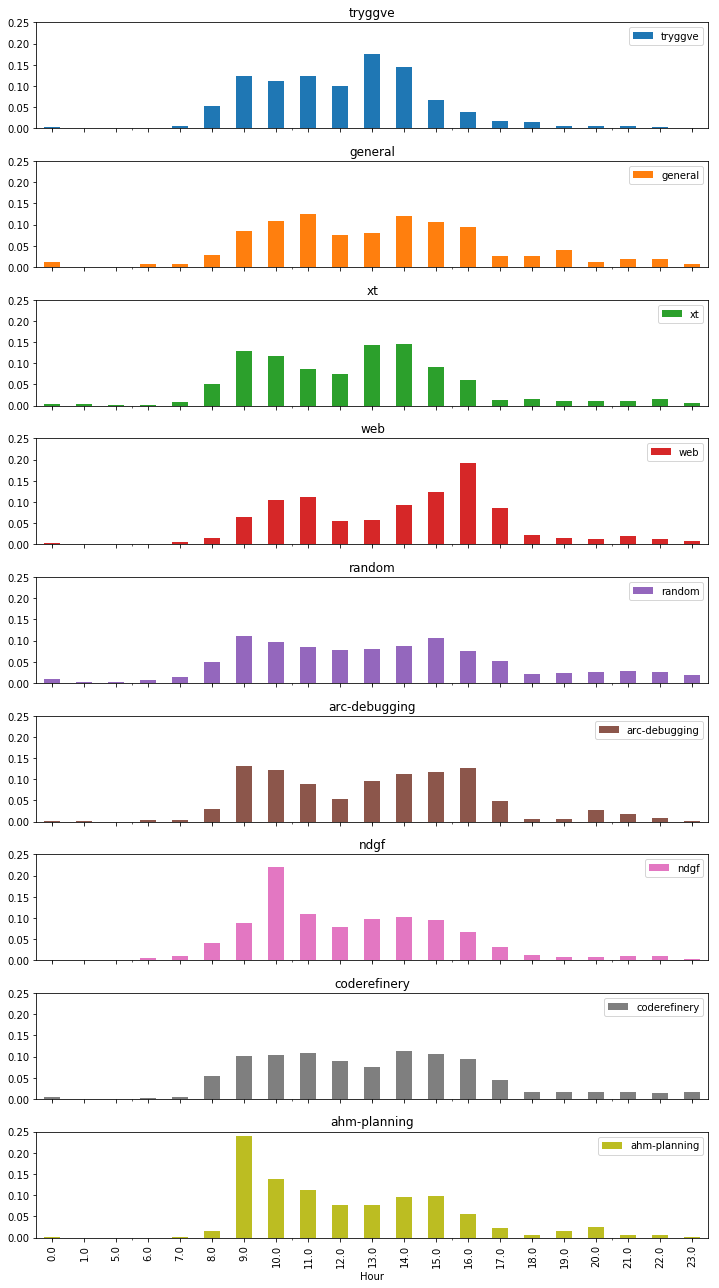

In [53]:
df_hours.plot(kind="bar",subplots=True,figsize=(10,18),ylim=(0,0.25));
plt.tight_layout()

> **Exercise:** Do the same analysis but splitting into weekdays!   
> (hint: format specifier %A gives the weekday)